<a href="https://colab.research.google.com/github/Sonali-Kotni57/Deep-Learning-Lab/blob/main/Experiment_3_CNN_For_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Necessary imports**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

###**Loading the model**

In [ ]:
# loading the first part
vgg = models.vgg19(pretrained=True).features

# freezing the parameters
for param in vgg.parameters():
    param.requires_grad_(False)
    
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

##**Loading content and style images**

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

###**Getting features**



In [ ]:
# Here you must write the path of your content image
content_image_path = '/content/sample_data/Content image.jpg' 

content = load_image(content_image_path).to(device)

# Here you must write the path of your style image
style_image_path = '/content/sample_data/Style image.jpg'

# Resize style to match content.
style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

In [ ]:
def get_features(image, model, layers=None):

    # The layers that are mentioned in Gatys et al (2016) paper
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28' : 'conv5_1'}
            
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

###**The Gram matrix**



In [ ]:
def gram_matrix(tensor):
  
    ## reshape it, so we are multiplying the features for each channel
    tensor = tensor.view(tensor.shape[1], tensor.shape[2]*tensor.shape[3])
    
    ## calculate the gram matrix
    gram = torch.mm(tensor,tensor.t())
    
    return gram 

###**Getting features for style and content images**



In [ ]:
# get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initalizing our target image
target = content.clone().requires_grad_(True).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


###**Display an image**


In [ ]:
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

###**Weights**


In [ ]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

###**Updating the Target image**


Total loss:  35113964.0


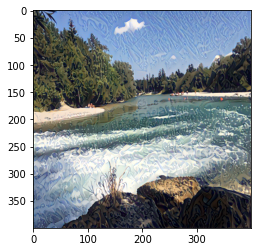

Total loss:  14730883.0


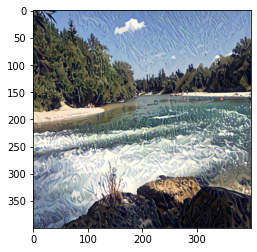

Total loss:  9323169.0


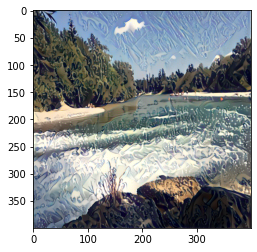

Total loss:  6831364.0


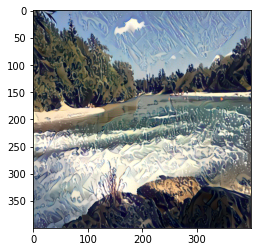

Total loss:  5351322.5


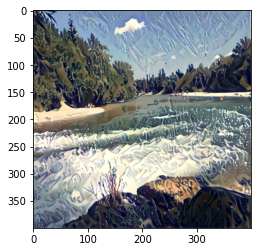

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image    
    target_features = get_features(target, vgg)
    
    # calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
      
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer]* torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    # calculate the *total* loss
    total_loss = content_weight*content_loss + style_weight*style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

###**Displaying the final result**

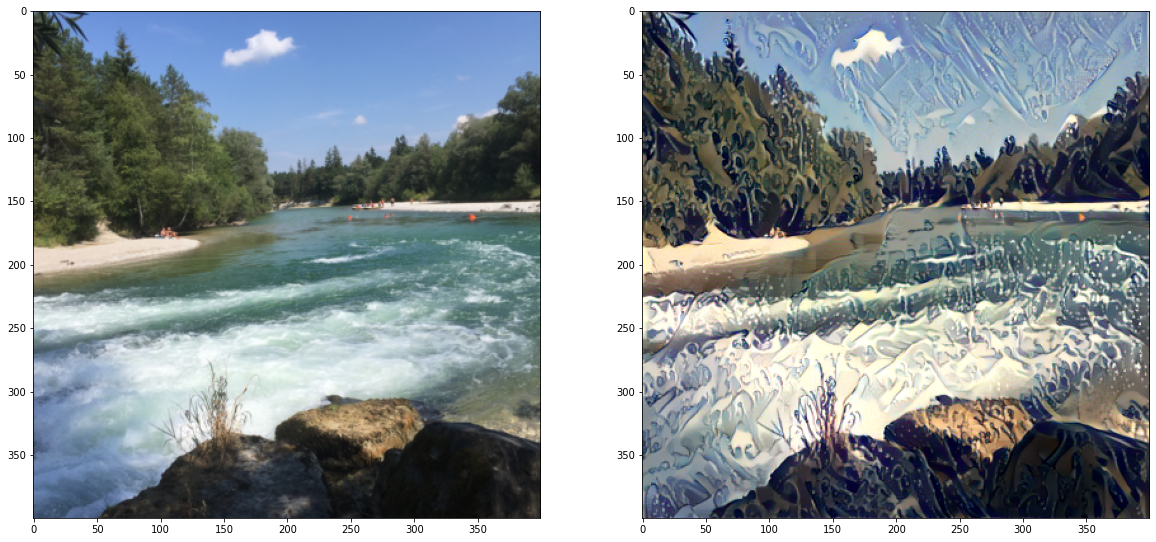

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))